In [19]:
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
import os
import sqlite3
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # настройка для задействования AVX инструкций процессора при обучении нейросети


In [10]:
def corel_dict_creator(data_list):
    """Возвращает словарь, где ключ - обратный номер столбца данных для тренировки,
     а значения - номера столбцов с которыми есть корреляция более 27% и сам столбец для тренировки"""
    corel_dict = dict()
    for y in range(-1, -5, -1):  # от -1 до -4 - столбцы с прогнозируемыми данными для тренировки нейросети
        for i in range(1, 80):  # от 1 до 79 - столбцы с исходными данными
            cut = [i, y]
            corel_data = data_list[:, cut]
            mask = np.any(np.isnan(corel_data) | np.equal(corel_data, 0), axis=1)  # удаляет строки с non элементами
            corel_data = corel_data[~mask]

            if len(corel_data) > 50000:
                cor = np.corrcoef(corel_data[:, 0], corel_data[:, 1])[0, 1]
                if abs(cor) >= 0.27:  # экспериментально выбранный порог допустимой корреляции данных
                    if y in corel_dict.keys():
                        corel_dict[y].append(i)
                    else:
                        corel_dict[y] = [i]
                    # print(f'Столбцы {y} -> {i} корреляция: {round(cor, 2)}')
        corel_dict[y].append(y)
    # print(corel_dict)
    return corel_dict


In [11]:
def neural_training(corel_dict, data_list):
    """На вход получает словарь с номерами коррелирующих столбцов и список данных.
    Выбирает из списка данных, данные из коррелирующих столбцов для обучения нейросети.
    Записывает данные обученных нейросетей"""
    for i in corel_dict.keys():
        cut = corel_dict[i]
        training_data = data_list[:, cut]
        mask = np.any(np.isnan(training_data) | np.equal(training_data, 0), axis=1)  # удаляет строки с non элементами
        training_data = training_data[~mask]

        x = len(training_data[0]) - 1  # количество столбцов массива исходных данных для обучения
        initial_data = training_data[:, :x]  # исходные данные для обучения
        result_data = training_data[:, -1]  # данные результатов для тренировки

        model = Sequential()
        model.add(Dense(1, activation='linear', use_bias=True))
        model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
        model.fit(initial_data, result_data, epochs=20, batch_size=5)  # настройки чательности обучения
        scores = model.evaluate(initial_data, result_data)
        print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

        model_name = f'model_target{5+i}'
        model.save(model_name)  # сохранение модели для каждого target-столбца
# Полученная точность: для target1: 335%, для target2: 15%, для target3: 0,4%, target4: 18%


In [ ]:
# Чтение данных для обучения, поиск кореляций, обучение нейросети
data = np.genfromtxt("train_data_200k.csv", delimiter=",")
my_corel_dict = corel_dict_creator(data)
neural_training(my_corel_dict, data)


In [10]:
def average_values(data_list):
    """Заполняет non-значения в массиве средними значениями по полю."""

    count_sum_list = np.zeros((len(data_list[0]), 2))  # список,
    # где нулевой элемент вложенного списка - сумма значение по полю,
    # первый элемент вложенного списка - количество элементов по полю не равных non.
    for item in data_list:
        for i in range(len(item)):
            if not np.isnan(item[i]):
                count_sum_list[i][0] += item[i]
                count_sum_list[i][1] += 1

    average_values_list = np.zeros(len(data_list[0]))  # список средних значений по полю не равных non
    for i in range(len(average_values_list)):
        if count_sum_list[i][1] != 0:
            average_values_list[i] = count_sum_list[i][0] / count_sum_list[i][1]

    for item in data_list:  # заменяет значения равный non на средние значения по полю
        for i in range(len(item)):
            if np.isnan(item[i]):
                item[i] = average_values_list[i]

    return data_list


In [18]:
COREL_DICT = {-1: [59],
              -2: [1, 15, 19, 33, 49, 59, 67, 71, 75, 76],
              -3: [1, 15, 19, 49, 63, 67, 71, 75, 76],
              -4: [1, 15, 19, 49, 63, 67, 71, 75, 76]}  # словарь со столбцами лучше всего коррелирующих с данными


In [43]:
import pandas as pd

data = np.genfromtxt("test_data_100k.csv", delimiter=",")
data = np.delete(data, 0, axis=0)  # удаление заголовков

data = average_values(data)  # добавление средних значений вместо nan

# Преобразует массив в дата фрейм pandas. Заполняет non-значения медианными значениями. Обратно преобразует в массив numpy.
# Влияние на результат не отмечено.
# data_df = pd.DataFrame(data)
# data_df = data_df.fillna(data_df.median())
# data=data_df.to_numpy()

print('OK')


OK


In [41]:
def forecast_data(data_list):
    """На основании полученных данных возврящает словарь с прогнозными данными"""
    # получение данных target1
    model_target1 = keras.models.load_model('model_target1')
    cut = COREL_DICT[-4]
    explore_data_1 = data_list[:, cut]
    forecast_target1 = np.array(model_target1(explore_data_1))

    # получение данных target2
    model_target2 = keras.models.load_model('model_target2')
    cut = COREL_DICT[-3]
    explore_data_2 = data_list[:, cut]
    forecast_target2 = np.array(model_target2(explore_data_2))

    # получение данных target3
    model_target3 = keras.models.load_model('model_target3')
    cut = COREL_DICT[-2]
    explore_data_3 = data_list[:, cut]
    forecast_target3 = np.array(model_target3(explore_data_3))

    # получение данных target4
    model_target4 = keras.models.load_model('model_target4')
    cut = COREL_DICT[-1]
    explore_data_4 = data_list[:, cut]
    forecast_target4 = np.array(model_target4(explore_data_4))

    forecast = np.hstack((forecast_target1, forecast_target2, forecast_target3, forecast_target4))
    return forecast


In [42]:
# Запись полученных прогнозных данных в файл
forecast = forecast_data(data)
np.savetxt("result_data100k.csv", forecast, delimiter=",")
print('OK')


OK


In [ ]:
# Создание БД и таблиц с исходными данными и прогнозными
conn = sqlite3.connect('data_base.db')
cur = conn.cursor()
request = "CREATE TABLE IF NOT EXISTS initial_data(id INTEGER PRIMARY KEY"
for i in range(1, 80):
    request += f', tag{i} REAL'
request += ');'
cur.execute(request)

request = "CREATE TABLE IF NOT EXISTS result_data(id INTEGER PRIMARY KEY," \
          " target1 REAL, target2 REAL, target3 REAL, target4 REAL);"
cur.execute(request)
conn.commit()


In [13]:
def insert_request(insert_list):
    """Формирует SQL-запрос для добавления новых исходных данных"""
    if len(insert_list) == 79:
        request = "INSERT INTO initial_data(tag1"
        for i in range(2, 80):
            request += f', tag{i}'
        request += ') VALUES ('
        for i in insert_list:
            request += f'{i}, '
        request = request[:-2]
        request += ');'
        return request
    else:
        print('неверная длинна строки')
        

In [14]:
# добавляет в БД выборку с исходными данными
conn = sqlite3.connect('data_base.db')
cur = conn.cursor()
for item in data[81:100]:  # вставляет 40 элементов
    request = insert_request(item[1:])
    cur.execute(request)
conn.commit()
print('OK')


OK


In [55]:
from numpy import float64
# получение из БД исходных данных для которых отсутствуют прогнозные данные:
conn = sqlite3.connect('data_base.db')
cur = conn.cursor()
cur.execute("SELECT * FROM initial_data "
            "LEFT OUTER JOIN result_data ON initial_data.id = result_data.id WHERE result_data.id IS NULL;")

explore_data = np.array(cur.fetchall()) # преобразование данных в nympy массив
explore_data = np.asarray(explore_data, dtype=float64)

forecast_data_list = forecast_data(explore_data) # получение прогнозных данных
forecast_data_list = np.hstack((explore_data[:, :1], forecast_data_list)) # добавляет к прогнозным данным столбец с id - равных исходным данным

cur.executemany("INSERT INTO result_data VALUES (?,?,?,?,?)", forecast_data_list) # сохранение полученных прогнозов в БД
conn.commit()
print('OK')


OK


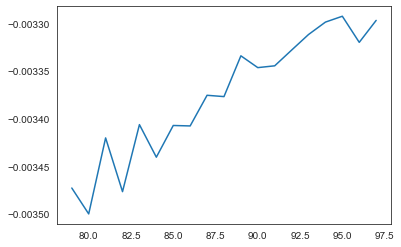

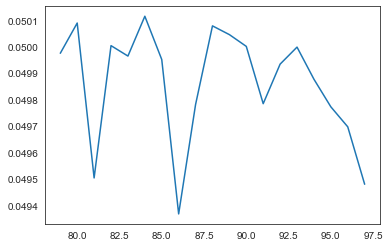

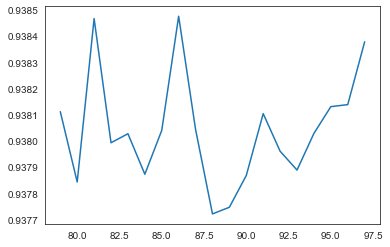

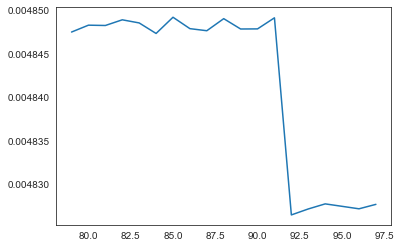

OK


In [70]:
import matplotlib.pyplot as plt

# Построение графиков по прогнозным данным добавленным в БД
plt.plot(forecast_data_list[:, 0], forecast_data_list[:, 1])
plt.show()
plt.plot(forecast_data_list[:, 0], forecast_data_list[:, 2])
plt.show()
plt.plot(forecast_data_list[:, 0], forecast_data_list[:, 3])
plt.show()
plt.plot(forecast_data_list[:, 0], forecast_data_list[:, 4])
plt.show()
print("OK")